In [0]:
from pandas import read_csv
import numpy as np

#ガス生産量データ
production_of_gas_data = read_csv('https://raw.githubusercontent.com/jamesrobertlloyd/gpss-research/master/data/tsdlr_5050/monthly-production-of-gas-in-aus-train.csv', header=None, names=["Date", "production-of-gas"])
#日付でソート
production_of_gas_data = production_of_gas_data.sort_values(by=['Date'])
#np.log()で対数にして、np.nan_to_num()でnp.nanを０に変換
X_gas = np.nan_to_num(np.log(production_of_gas_data["production-of-gas"].values + 1))
#日付を取り出し
X_gas_day = production_of_gas_data["Date"].values


In [74]:
production_of_gas_data.head()

,Date,production-of-gas
28,1956.087671,1646.0
233,1956.167123,1794.0
137,1956.252055,1878.0
215,1956.419178,2321.0
147,1956.501370,2468.0


In [0]:
#複数の連続データセットをlook_backを利用してデータとラベルに分ける
from numpy import array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense


look_back = 5

#データセット作成
dataset = [X_gas]

def create_dataset(dataset, look_back=1):
    x, y = [], []
    for ii in dataset:
        for i in range(len(ii) - look_back):
            a = i + look_back
            x.append(ii[i:a])
            y.append(ii[a])

    return np.array(x), np.array(y)

X,y = create_dataset(dataset,look_back)
X = X.reshape((X.shape[0], X.shape[1], 1))

In [116]:
X[:3]

array([[[7.40671073],
        [7.4927603 ],
        [7.538495  ],
        [7.75018416],
        [7.81156849]],

       [[7.4927603 ],
        [7.538495  ],
        [7.75018416],
        [7.81156849],
        [7.79028238]],

       [[7.538495  ],
        [7.75018416],
        [7.81156849],
        [7.79028238],
        [7.68937111]]])

In [117]:
y[:3]

array([7.79028238, 7.68937111, 7.66011432])

In [0]:
#トレーニング用と検証用のデータセットに8:2で分割

split_n = int(len(X)*0.8)

X_train = X[:split_n]
X_test  = X[split_n:]
y_train = y[:split_n]
y_test  = y[split_n:]

In [134]:
# model作成
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(5, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


# fit
model.fit(X_train, y_train, epochs=1000, verbose=0)

In [0]:
#検証用データで予測

predicted_y = []

for i in range(X_test.shape[0]):
    x_input = X_test[i]
    x_input = x_input.reshape((1, 5, 1))
    y = model.predict(x_input, verbose=1)
   
    predicted_y.append(y[0][0])

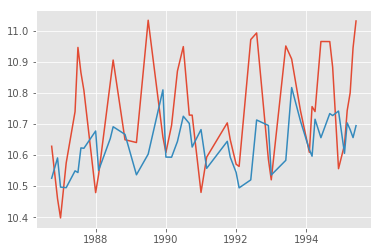

In [136]:
#予測値と正解値を比較

%matplotlib inline 
import matplotlib.pyplot as plt
plt.style.use('ggplot')

start = split_n + look_back

plt.plot(X_gas_day[start:],y_test)
plt.plot(X_gas_day[start:],predicted_y)

###データ量が少ない為精度は低いが、傾向は反映している

In [0]:
########## LSTMで連続値を予測する方法 #########

In [150]:
from numpy import array
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.optimizers import Adam

Using TensorFlow backend.


In [0]:
"""
単一データを学習させる際のやり方
例えば、６時間分のデータが３日分あるとする。
その場合に、７時間目以降の３時間分の目的変数を予測する。

"""

X = np.array([  #6h分のデータ
                        [1,2,3,4,5,6],#day 1
                        [2,3,4,5,6,7],#day 2
                        [3,4,5,6,7,8]#day 3
                      ])
#shapeは(3,6)


y = np.array([
                        [2,3,4],#day 1の7時間目以降の向こう3時間分目的変数データ
                        [3,4,5],#day 2の7時間目以降の向こう3時間分目的変数データ
                        [4,5,6]#day 3の7時間目以降の向こう3時間分目的変数データ
                        ])
#shapeは(3,3)

In [152]:
#Xのshapeを(3,6)から(3,6,1)に変更
X = X.reshape(3,6,1)
X.shape

(3, 6, 1)

In [0]:
# model作成
model = Sequential()

#input_shapeに注意
model.add(LSTM(128, activation='relu', input_shape=(6, 1)))

#outputを[3,4,5]のような連続値にしたい場合は、最終Dense layerの数を連続値の個数と揃えてやる
model.add(Dense(3))

optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='mse')


In [0]:
model.fit(X, y, epochs=300, verbose=0)

In [155]:
#予測データ準備
pre = np.array([[4,5,6,7,8,9]])

#predictするためにshapeを(1,6)から(1,6,1)に変更
pre = pre.reshape(1,6,1)


#予測値として期待される値は[5,6,7]

#予測実行
model.predict(pre)

array([[5.205141 , 6.189311 , 7.2238035]], dtype=float32)

###期待した予測値が出ている

In [0]:
"""
複数のデータを一緒に学習させる際のやり方
例えば、気温、湿度、風速、積雪、それぞれ６時間分のデータが３日分あるとする。
そこから７時間目以降の向こう３時間の目的変数を予測するとする。

"""

X2 = np.array([    #気温の６h分    湿度の６h分     風速の６h分      積雪の６h分
                            [[1,2,3,4,5,6],[1,2,3,4,5,6],[1,2,3,4,5,6],[1,2,3,4,5,6]],#day 1
                            [[2,3,4,5,6,7],[2,3,4,5,6,7],[2,3,4,5,6,7],[2,3,4,5,6,7]],#day 2
                            [[3,4,5,6,7,8],[3,4,5,6,7,8],[3,4,5,6,7,8],[3,4,5,6,7,8]]#day 3
                        ])
#shapeは(3,4,6)


y2 = np.array([
                            [2,3,4],#day 1の7時間目以降の向こう3時間分目的変数データ
                            [3,4,5],#day 2の7時間目以降の向こう3時間分目的変数データ
                            [4,5,6]#day 3の7時間目以降の向こう3時間分目的変数データ
                        ])
#shapeは(3,3)


In [0]:
# model作成
model = Sequential()

#input_shapeに注意
model.add(LSTM(128, activation='relu', input_shape=(4, 6)))

#outputを[3,4,5]のような連続値にしたい場合は、最終Dense layerの数を連続値の個数と揃えてやる
model.add(Dense(3))
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='mse')


In [0]:
model.fit(X2, y2, epochs=300, verbose=0)

In [159]:
#予測データ準備
pre2 = np.array([
                            [[4,5,6,7,8,9],[4,5,6,7,8,9],[4,5,6,7,8,9],[4,5,6,7,8,9]]
                            ])
pre2.shape
#shapeは(1,4,6)

#予測値として期待される値は[5,6,7]


#予測実行
model.predict(pre2)

array([[5.175714 , 6.0294175, 6.991619 ]], dtype=float32)

###期待した予測値が出ている